In [1]:
!pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.0/102.0 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 MB 13.8 MB/s eta 0:00:00
  Attempting uninstall: jax-cuda12-pjrt
    Found existing installation: jax-cuda12-pjrt 0.4.33
    Uninstalling jax-cuda12-pjrt-0.4.33:
      Successfully uninstalled jax-cuda12-pjrt-0.4.33
  Attempting uninstall: nvidia-cuda-nvcc-cu12
    Found existing installation: nvidia-cuda-nvcc-cu12 12.5.82
    Uninstalling nvidia-cuda-nvcc-cu12-12.5.82:
      Successfully uninstalled nvidia-cuda-nvcc-cu12-12.5.82
  Attempting uninstall: jax-cuda12-plugin
    Found existing installation: jax-cuda12-plugin 0.4.33
    Uninst

In [2]:
!pip install swig
!pip install gymnasium[box2d]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp311-cp311-linux_x86_64.whl size=2379449 sha256=2b93081f60fda17ca3c6211a86f627f7cd354bf9bf6a741b111f61dac14e1352
  Stored in directory: /root/.cache/pip/wheels/ab/f1/0c/d56f4a2bdd12bae0a0693ec33f2f0daadb5eb9753c78fa5308
Successfully built box2d-py


In [19]:
import flax.linen as nn
import gymnasium as gym
from gymnasium.wrappers import FlattenObservation
from gymnasium.utils import seeding

from functools import partial
import numpy as np
import wandb
import jax
import optax
import collections
import jax.numpy as jnp
from flax import struct
from tqdm import trange
import matplotlib.pyplot as plt
from flax.core import frozen_dict
from flax.training.train_state import TrainState

from typing import Optional, Any, Union, Sequence, Dict, Tuple, Type, Iterable, Callable
import moviepy.editor
DataType = Union[np.ndarray, Dict[str, "DataType"]]
DatasetDict = Dict[str, DataType]
default_init = nn.initializers.xavier_uniform

In [20]:
class UniversalSeed(gym.Wrapper):
    def seed(self, seed: int):
        seeds = self.env.seed(seed)
        self.env.observation_space.seed(seed)
        self.env.action_space.seed(seed)
        return seeds

def wrap_gym(env: gym.Env, rescale_actions: bool = True) -> gym.Env:
    # env = SinglePrecision(env)
    env = UniversalSeed(env)
    if rescale_actions:
        env = gym.wrappers.RescaleAction(env, -1, 1)

    if isinstance(env.observation_space, gym.spaces.Dict):
        env = FlattenObservation(env)

    env = gym.wrappers.ClipAction(env)

    return env

In [21]:
env = gym.make("BipedalWalker-v3", render_mode="rgb_array")
env = wrap_gym(env, rescale_actions=True)
env = video = gym.wrappers.RecordVideo(env, 'cartpole_video')
observation, _ = env.reset()
for i in trange(10000):
    action = env.action_space.sample()
    next_observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    if done:
        print('DONE!')
        break
env.close()
moviepy.editor.ipython_display("cartpole_video/rl-video-episode-0.mp4")

  0%|          | 49/10000 [00:00<00:55, 178.70it/s]


DONE!


In [22]:
@partial(jax.jit, static_argnames="apply_fn")
def _sample_actions(rng, apply_fn, params, observations: np.ndarray) -> np.ndarray:
    key, rng = jax.random.split(rng)
    dist = apply_fn({"params": params}, observations)
    return dist.sample(seed=key), rng

@partial(jax.jit, static_argnames="apply_fn")
def _eval_actions(apply_fn, params, observations: np.ndarray) -> np.ndarray:
    dist = apply_fn({"params": params}, observations)
    return dist.mode()

class Agent(struct.PyTreeNode):
    actor: TrainState
    rng: Any

    def eval_actions(self, observations: np.ndarray) -> np.ndarray:
        actions = _eval_actions(self.actor.apply_fn, self.actor.params, observations)
        return np.asarray(actions), self.replace(rng=self.rng)

    def sample_actions(self, observations: np.ndarray) -> np.ndarray:
        actions, new_rng = _sample_actions(
            self.rng, self.actor.apply_fn, self.actor.params, observations
        )
        return np.asarray(actions), self.replace(rng=new_rng)


In [23]:

def cosine_beta_schedule(timesteps, s = 0.008):
    """
    cosine schedule
    as proposed in https://openreview.net/forum?id=-NEXDKk8gZ
    """
    steps = timesteps + 1
    t = jnp.linspace(0, timesteps, steps) / timesteps
    alphas_cumprod = jnp.cos((t + s) / (1 + s) * jnp.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return jnp.clip(betas, 0, 0.999)

def linear_beta_schedule(timesteps, beta_start=1e-4, beta_end=2e-2):
    betas = jnp.linspace(
        beta_start, beta_end, timesteps
    )
    return betas

def vp_beta_schedule(timesteps):
    t = jnp.arange(1, timesteps + 1)
    T = timesteps
    b_max = 10.
    b_min = 0.1
    alpha = jnp.exp(-b_min / T - 0.5 * (b_max - b_min) * (2 * t - 1) / T ** 2)
    betas = 1 - alpha
    return betas

class FourierFeatures(nn.Module):
    output_size: int
    learnable: bool = True

    @nn.compact
    def __call__(self, x: jnp.ndarray):
        if self.learnable:
            w = self.param('kernel', nn.initializers.normal(0.2),
                           (self.output_size // 2, x.shape[-1]), jnp.float32)
            f = 2 * jnp.pi * x @ w.T
        else:
            half_dim = self.output_size // 2
            f = jnp.log(10000) / (half_dim - 1)
            f = jnp.exp(jnp.arange(half_dim) * -f)
            f = x * f
        return jnp.concatenate([jnp.cos(f), jnp.sin(f)], axis=-1)

class DDPM(nn.Module):
    cond_encoder_cls: Type[nn.Module]
    reverse_encoder_cls: Type[nn.Module]
    time_preprocess_cls: Type[nn.Module]

    @nn.compact
    def __call__(self,
                 s: jnp.ndarray,
                 a: jnp.ndarray,
                 time: jnp.ndarray,
                 training: bool = False):

        t_ff = self.time_preprocess_cls()(time)
        cond = self.cond_encoder_cls()(t_ff, training=training)
        reverse_input = jnp.concatenate([a, s, cond], axis=-1)

        return self.reverse_encoder_cls()(reverse_input, training=training)

@partial(jax.jit, static_argnames=('actor_apply_fn', 'act_dim', 'T', 'clip_sampler', 'training'))
def ddpm_sampler(actor_apply_fn, actor_params, T, rng, act_dim, observations, alphas, alpha_hats, betas, sample_temperature, clip_sampler, training = False):

    batch_size = observations.shape[0]

    def fn(input_tuple, time):
        current_x, rng = input_tuple

        input_time = jnp.expand_dims(
            jnp.array([time]).repeat(current_x.shape[0]), axis=1)
        eps_pred = actor_apply_fn(
            {"params": actor_params},
            observations, current_x,
            input_time, training=training)

        alpha_1 = 1 / jnp.sqrt(alphas[time])
        alpha_2 = ((1 - alphas[time]) / (jnp.sqrt(1 - alpha_hats[time])))
        current_x = alpha_1 * (current_x - alpha_2 * eps_pred)

        rng, key = jax.random.split(rng, 2)
        z = jax.random.normal(
            key, shape=(observations.shape[0], current_x.shape[1]),)

        z_scaled = sample_temperature * z
        current_x = current_x + (time > 0) * (jnp.sqrt(betas[time]) * z_scaled)
        current_x = jnp.clip(current_x, -1, 1) if clip_sampler else current_x
        return (current_x, rng), ()

    key, rng = jax.random.split(rng, 2)
    (action_0, rng), () = jax.lax.scan(
        fn, (jax.random.normal(key, (batch_size, act_dim)), rng),
        jnp.arange(T-1, -1, -1), unroll=5)
    action_0 = jnp.clip(action_0, -1, 1)
    return action_0, rng


In [24]:

def _check_lengths(dataset_dict: DatasetDict, dataset_len: Optional[int] = None) -> int:
    for v in dataset_dict.values():
        if isinstance(v, dict):
            dataset_len = dataset_len or _check_lengths(v, dataset_len)
        elif isinstance(v, np.ndarray):
            item_len = len(v)
            dataset_len = dataset_len or item_len
            assert dataset_len == item_len, "Inconsistent item lengths in the dataset."
        else:
            raise TypeError("Unsupported type.")
    return dataset_len


def _subselect(dataset_dict: DatasetDict, index: np.ndarray) -> DatasetDict:
    new_dataset_dict = {}
    for k, v in dataset_dict.items():
        if isinstance(v, dict):
            new_v = _subselect(v, index)
        elif isinstance(v, np.ndarray):
            new_v = v[index]
        else:
            raise TypeError("Unsupported type.")
        new_dataset_dict[k] = new_v
    return new_dataset_dict


def _sample(
    dataset_dict: Union[np.ndarray, DatasetDict], indx: np.ndarray
) -> DatasetDict:
    if isinstance(dataset_dict, np.ndarray):
        return dataset_dict[indx]
    elif isinstance(dataset_dict, dict):
        batch = {}
        for k, v in dataset_dict.items():
            batch[k] = _sample(v, indx)
    else:
        raise TypeError("Unsupported type.")
    return batch


class Dataset(object):
    def __init__(self, dataset_dict: DatasetDict, seed: Optional[int] = None):
        self.dataset_dict = dataset_dict
        self.dataset_len = _check_lengths(dataset_dict)

        # Seeding similar to OpenAI Gym:
        # https://github.com/openai/gym/blob/master/gym/spaces/space.py#L46
        self._np_random = None
        self._seed = None
        if seed is not None:
            self.seed(seed)

    @property
    def np_random(self) -> np.random.RandomState:
        if self._np_random is None:
            self.seed()
        return self._np_random

    def seed(self, seed: Optional[int] = None) -> list:
        self._np_random, self._seed = seeding.np_random(seed)
        return [self._seed]

    def __len__(self) -> int:
        return self.dataset_len

    def sample(
        self,
        batch_size: int,
        keys: Optional[Iterable[str]] = None,
        indx: Optional[np.ndarray] = None,
    ) -> frozen_dict.FrozenDict:
        if indx is None:
            if hasattr(self.np_random, "integers"):
                indx = self.np_random.integers(len(self), size=batch_size)
            else:
                indx = self.np_random.randint(len(self), size=batch_size)

        batch = dict()

        if keys is None:
            keys = self.dataset_dict.keys()

        for k in keys:
            if isinstance(self.dataset_dict[k], dict):
                batch[k] = _sample(self.dataset_dict[k], indx)
            else:
                batch[k] = self.dataset_dict[k][indx]

        return frozen_dict.freeze(batch)

    def sample_jax(self, batch_size: int, keys: Optional[Iterable[str]] = None):
        if not hasattr(self, "rng"):
            self.rng = jax.random.PRNGKey(self._seed or 42)

            if keys is None:
                keys = self.dataset_dict.keys()

            jax_dataset_dict = {k: self.dataset_dict[k] for k in keys}
            jax_dataset_dict = jax.device_put(jax_dataset_dict)

            @jax.jit
            def _sample_jax(rng):
                key, rng = jax.random.split(rng)
                indx = jax.random.randint(
                    key, (batch_size,), minval=0, maxval=len(self)
                )
                return rng, jax.tree_map(
                    lambda d: jnp.take(d, indx, axis=0), jax_dataset_dict
                )

            self._sample_jax = _sample_jax

        self.rng, sample = self._sample_jax(self.rng)
        return sample

    def split(self, ratio: float) -> Tuple["Dataset", "Dataset"]:
        assert 0 < ratio and ratio < 1
        train_index = np.index_exp[: int(self.dataset_len * ratio)]
        test_index = np.index_exp[int(self.dataset_len * ratio) :]

        index = np.arange(len(self), dtype=np.int32)
        self.np_random.shuffle(index)
        train_index = index[: int(self.dataset_len * ratio)]
        test_index = index[int(self.dataset_len * ratio) :]

        train_dataset_dict = _subselect(self.dataset_dict, train_index)
        test_dataset_dict = _subselect(self.dataset_dict, test_index)
        return Dataset(train_dataset_dict), Dataset(test_dataset_dict)

    def _trajectory_boundaries_and_returns(self) -> Tuple[list, list, list]:
        episode_starts = [0]
        episode_ends = []

        episode_return = 0
        episode_returns = []

        for i in range(len(self)):
            episode_return += self.dataset_dict["rewards"][i]

            if self.dataset_dict["dones"][i]:
                episode_returns.append(episode_return)
                episode_ends.append(i + 1)
                if i + 1 < len(self):
                    episode_starts.append(i + 1)
                episode_return = 0.0

        return episode_starts, episode_ends, episode_returns

    def filter(
        self, take_top: Optional[float] = None, threshold: Optional[float] = None
    ):
        assert (take_top is None and threshold is not None) or (
            take_top is not None and threshold is None
        )

        (
            episode_starts,
            episode_ends,
            episode_returns,
        ) = self._trajectory_boundaries_and_returns()

        if take_top is not None:
            threshold = np.percentile(episode_returns, 100 - take_top)

        bool_indx = np.full((len(self),), False, dtype=bool)

        for i in range(len(episode_returns)):
            if episode_returns[i] >= threshold:
                bool_indx[episode_starts[i] : episode_ends[i]] = True

        self.dataset_dict = _subselect(self.dataset_dict, bool_indx)

        self.dataset_len = _check_lengths(self.dataset_dict)

    def normalize_returns(self, scaling: float = 1000):
        (_, _, episode_returns) = self._trajectory_boundaries_and_returns()
        self.dataset_dict["rewards"] /= np.max(episode_returns) - np.min(
            episode_returns
        )
        self.dataset_dict["rewards"] *= scaling


In [25]:

def _init_replay_dict(
    obs_space: gym.Space, capacity: int
) -> Union[np.ndarray, DatasetDict]:
    if isinstance(obs_space, gym.spaces.Box):
        return np.empty((capacity, *obs_space.shape), dtype=obs_space.dtype)
    elif isinstance(obs_space, gym.spaces.Dict):
        data_dict = {}
        for k, v in obs_space.spaces.items():
            data_dict[k] = _init_replay_dict(v, capacity)
        return data_dict
    else:
        raise TypeError()


def _insert_recursively(
    dataset_dict: DatasetDict, data_dict: DatasetDict, insert_index: int
):
    if isinstance(dataset_dict, np.ndarray):
        dataset_dict[insert_index] = data_dict
    elif isinstance(dataset_dict, dict):
        assert dataset_dict.keys() == data_dict.keys()
        for k in dataset_dict.keys():
            _insert_recursively(dataset_dict[k], data_dict[k], insert_index)
    else:
        raise TypeError()


class ReplayBuffer(Dataset):
    def __init__(
        self,
        observation_space: gym.Space,
        action_space: gym.Space,
        capacity: int,
        next_observation_space: Optional[gym.Space] = None,
    ):
        if next_observation_space is None:
            next_observation_space = observation_space

        observation_data = _init_replay_dict(observation_space, capacity)
        next_observation_data = _init_replay_dict(next_observation_space, capacity)
        dataset_dict = dict(
            observations=observation_data,
            next_observations=next_observation_data,
            actions=np.empty((capacity, *action_space.shape), dtype=action_space.dtype),
            rewards=np.empty((capacity,), dtype=np.float32),
            masks=np.empty((capacity,), dtype=np.float32),
            dones=np.empty((capacity,), dtype=bool),
        )

        super().__init__(dataset_dict)

        self._size = 0
        self._capacity = capacity
        self._insert_index = 0

    def __len__(self) -> int:
        return self._size

    def insert(self, data_dict: DatasetDict):
        _insert_recursively(self.dataset_dict, data_dict, self._insert_index)

        self._insert_index = (self._insert_index + 1) % self._capacity
        self._size = min(self._size + 1, self._capacity)

    def get_iterator(self, queue_size: int = 2, sample_args: dict = {}):
        # See https://flax.readthedocs.io/en/latest/_modules/flax/jax_utils.html#prefetch_to_device
        # queue_size = 2 should be ok for one GPU.

        queue = collections.deque()

        def enqueue(n):
            for _ in range(n):
                data = self.sample(**sample_args)
                queue.append(jax.device_put(data))

        enqueue(queue_size)
        while queue:
            yield queue.popleft()
            enqueue(1)


In [26]:
class MLP(nn.Module):
    hidden_dims: Sequence[int]
    activations: Callable[[jnp.ndarray], jnp.ndarray] = nn.relu
    activate_final: bool = False
    use_layer_norm: bool = False
    scale_final: Optional[float] = None
    dropout_rate: Optional[float] = None

    @nn.compact
    def __call__(self, x: jnp.ndarray, training: bool = False) -> jnp.ndarray:
        if self.use_layer_norm:
            x = nn.LayerNorm()(x)
        for i, size in enumerate(self.hidden_dims):
            if i + 1 == len(self.hidden_dims) and self.scale_final is not None:
                x = nn.Dense(size, kernel_init=default_init(self.scale_final))(x)
            else:
                x = nn.Dense(size, kernel_init=default_init())(x)

            if i + 1 < len(self.hidden_dims) or self.activate_final:
                if self.dropout_rate is not None and self.dropout_rate > 0:
                    x = nn.Dropout(rate=self.dropout_rate)(
                        x, deterministic=not training
                    )
                x = self.activations(x)
        return x


In [27]:
tree_map = jax.tree_util.tree_map
sg = lambda x: tree_map(jax.lax.stop_gradient, x)

def mish(x):
    return x * jnp.tanh(nn.softplus(x))

class StateActionValue(nn.Module):
    base_cls: nn.Module

    @nn.compact
    def __call__(
        self, observations: jnp.ndarray, actions: jnp.ndarray, *args, **kwargs
    ) -> jnp.ndarray:
        inputs = jnp.concatenate([observations, actions], axis=-1)
        outputs = self.base_cls()(inputs, *args, **kwargs)

        value = nn.Dense(1, kernel_init=default_init())(outputs)

        return jnp.squeeze(value, -1)

def tensorstats(tensor, prefix=None):
  assert tensor.size > 0, tensor.shape
  metrics = {
      'mean': tensor.mean(),
      'std': tensor.std(),
      'mag': jnp.abs(tensor).max(),
      'min': tensor.min(),
      'max': tensor.max(),
  }
  if prefix:
    metrics = {f'{prefix}_{k}': v for k, v in metrics.items()}
  return metrics

class ScoreMatchingLearner(Agent):
    score_model: TrainState
    critic_1: TrainState
    critic_2: TrainState
    target_critic_1: TrainState
    target_critic_2: TrainState

    discount: float
    tau: float
    act_dim: int = struct.field(pytree_node=False)
    T: int = struct.field(pytree_node=False)
    clip_sampler: bool = struct.field(pytree_node=False)
    ddpm_temperature: float
    betas: jnp.ndarray
    alphas: jnp.ndarray
    alpha_hats: jnp.ndarray
    # global scaling factor for grad_a Q(s, a)
    M_q: float

    @classmethod
    def create(
        cls,
        seed: int,
        observation_space: gym.spaces.Space,
        action_space: gym.spaces.Box,
        actor_architecture: str = 'mlp',
        actor_lr: Union[float, optax.Schedule] = 3e-4,
        critic_lr: float = 3e-4,
        critic_hidden_dims: Sequence[int] = (256, 256),
        actor_hidden_dims: Sequence[int] = (256, 256, 256),
        discount: float = 0.99,
        tau: float = 0.005,
        ddpm_temperature: float = 1.0,
        actor_layer_norm: bool = False,
        T: int = 5,
        time_dim: int = 64,
        clip_sampler: bool = True,
        beta_schedule: str = 'vp',
        decay_steps: Optional[int] = int(2e6),
        M_q: float = 1,
    ):

        rng = jax.random.PRNGKey(seed)
        rng, actor_key, critic_key = jax.random.split(rng, 3)
        actions = action_space.sample()
        observations = observation_space.sample()
        action_dim = action_space.shape[-1]

        # Time embedding network.
        preprocess_time_cls = partial(
            FourierFeatures, output_size=time_dim, learnable=True)

        cond_model_cls = partial(
            MLP, hidden_dims=(128, 128), activations=mish,
            activate_final=False)

        if decay_steps is not None:
            actor_lr = optax.cosine_decay_schedule(actor_lr, decay_steps)

        if actor_architecture == 'mlp':
            base_model_cls = partial(MLP,
                hidden_dims=tuple(list(actor_hidden_dims) + [action_dim]),
                activations=mish, use_layer_norm=actor_layer_norm,
                activate_final=False)

            actor_def = DDPM(time_preprocess_cls=preprocess_time_cls,
                             cond_encoder_cls=cond_model_cls,
                             reverse_encoder_cls=base_model_cls)
        else:
            raise ValueError(f'Invalid actor architecture: {actor_architecture}')

        time = jnp.zeros((1, 1))
        observations = jnp.expand_dims(observations, axis = 0)
        actions = jnp.expand_dims(actions, axis = 0)
        actor_params = actor_def.init(
            actor_key, observations, actions, time)['params']

        score_model = TrainState.create(
            apply_fn=actor_def.apply, params=actor_params,
            tx=optax.adam(learning_rate=actor_lr))

        # Initialize critics.
        critic_base_cls = partial(
            MLP, hidden_dims=critic_hidden_dims, activate_final=True)
        critic_def = StateActionValue(critic_base_cls)
        critic_key_1, critic_key_2 = jax.random.split(critic_key, 2)
        critic_params_1 = critic_def.init(critic_key_1, observations, actions)["params"]
        critic_params_2 = critic_def.init(critic_key_2, observations, actions)["params"]
        critic_1 = TrainState.create(
            apply_fn=critic_def.apply,
            params=critic_params_1,
            tx=optax.adam(learning_rate=critic_lr))
        critic_2 = TrainState.create(
            apply_fn=critic_def.apply,
            params=critic_params_2,
            tx=optax.adam(learning_rate=critic_lr))

        target_critic_def = StateActionValue(critic_base_cls)
        target_critic_1 = TrainState.create(
            apply_fn=target_critic_def.apply,
            params=critic_params_1,
            tx=optax.GradientTransformation(lambda _: None, lambda _: None),)
        target_critic_2 = TrainState.create(
            apply_fn=target_critic_def.apply,
            params=critic_params_2,
            tx=optax.GradientTransformation(lambda _: None, lambda _: None),)

        if beta_schedule == 'cosine':
            betas = jnp.array(cosine_beta_schedule(T))
        elif beta_schedule == 'linear':
            betas = jnp.linspace(1e-4, 2e-2, T)
        elif beta_schedule == 'vp':
            betas = jnp.array(vp_beta_schedule(T))
        else:
            raise ValueError(f'Invalid beta schedule: {beta_schedule}')

        alphas = 1 - betas
        alpha_hat = jnp.array([jnp.prod(alphas[:i + 1]) for i in range(T)])

        return cls(
            actor=None,
            score_model=score_model,
            critic_1=critic_1,
            critic_2=critic_2,
            target_critic_1=target_critic_1,
            target_critic_2=target_critic_2,
            tau=tau,
            discount=discount,
            rng=rng,
            betas=betas,
            alpha_hats=alpha_hat,
            act_dim=action_dim,
            T=T,
            alphas=alphas,
            ddpm_temperature=ddpm_temperature,
            clip_sampler=clip_sampler,
            M_q=M_q,
        )

    def update_q(agent, batch: DatasetDict) -> Tuple[Agent, Dict[str, float]]:
        (B, _) = batch['observations'].shape
        (_, A) = batch['actions'].shape

        # Sample actions for next state.
        key, rng = jax.random.split(agent.rng)
        next_actions, rng = ddpm_sampler(
            agent.score_model.apply_fn,
            agent.score_model.params,
            agent.T, rng, agent.act_dim,
            batch['next_observations'],
            agent.alphas, agent.alpha_hats,
            agent.betas, agent.ddpm_temperature,
            agent.clip_sampler)
        key, rng = jax.random.split(rng, 2)
        noise = jax.random.normal(key, shape=next_actions.shape) * 0.1
        next_actions = next_actions + noise
        next_actions = jnp.clip(next_actions, -1.0, 1.0)
        key, rng = jax.random.split(rng, 2)
        assert next_actions.shape == (B, A)

        # Compute target q.
        key, rng = jax.random.split(rng)
        next_q_1 = agent.target_critic_1.apply_fn(
            {"params": agent.target_critic_1.params}, batch["next_observations"],
            next_actions, True, rngs={"dropout": key})
        key, rng = jax.random.split(rng)
        next_q_2 = agent.target_critic_2.apply_fn(
            {"params": agent.target_critic_2.params}, batch["next_observations"],
            next_actions, True, rngs={"dropout": key})
        key, rng = jax.random.split(rng)
        next_v = jnp.stack([next_q_1, next_q_2], 0).min(0)
        target_q = batch["rewards"] + agent.discount * batch["masks"] * next_v
        metrics = tensorstats(target_q, 'target_q')
        assert target_q.shape == (B,)

        def critic_loss_fn(critic_params) -> Tuple[jnp.ndarray, Dict[str, float]]:
            q = agent.critic_1.apply_fn(
                {"params": critic_params},
                batch["observations"],
                batch["actions"], training=True)
            loss = ((q - sg(target_q)) ** 2)
            assert loss.shape == (B,)
            metrics = {**tensorstats(loss, 'c_loss'), **tensorstats(q, 'q')}
            return loss.mean(), metrics

        grads_c_1, metrics_c_1 = jax.grad(critic_loss_fn, has_aux=True)(agent.critic_1.params)
        metrics.update({f'{k}_1': v for k, v in metrics_c_1.items()})
        critic_1 = agent.critic_1.apply_gradients(grads=grads_c_1)

        grads_c_2, metrics_c_2 = jax.grad(critic_loss_fn, has_aux=True)(agent.critic_2.params)
        metrics.update({f'{k}_2': v for k, v in metrics_c_2.items()})
        critic_2 = agent.critic_2.apply_gradients(grads=grads_c_2)

        target_critic_1_params = optax.incremental_update(
            critic_1.params, agent.target_critic_1.params, agent.tau)
        target_critic_2_params = optax.incremental_update(
            critic_2.params, agent.target_critic_2.params, agent.tau)
        target_critic_1 = agent.target_critic_1.replace(params=target_critic_1_params)
        target_critic_2 = agent.target_critic_2.replace(params=target_critic_2_params)
        new_agent = agent.replace(
            critic_1=critic_1, critic_2=critic_2,
            target_critic_1=target_critic_1,
            target_critic_2=target_critic_2,
            rng=rng)
        return new_agent, metrics

    def update_actor(agent, batch: DatasetDict) -> Tuple[Agent, Dict[str, float]]:
        B, A = batch['actions'].shape

        # Forward process with RB actions.
        key, rng = jax.random.split(agent.rng, 2)
        time = jax.random.randint(key, (B,), 0, agent.T)
        key, rng = jax.random.split(rng, 2)
        noise_sample = jax.random.normal(
            key, (B, agent.act_dim))
        key, rng = jax.random.split(rng, 2)
        alpha_hats = agent.alpha_hats[time]
        time = jnp.expand_dims(time, axis=1)
        alpha_1 = jnp.expand_dims(jnp.sqrt(alpha_hats), axis=1)
        alpha_2 = jnp.expand_dims(jnp.sqrt(1 - alpha_hats), axis=1)
        noisy_actions = alpha_1 * batch['actions'] + alpha_2 * noise_sample
        key, rng = jax.random.split(rng, 2)

        # Compute dQ/da.
        critic_1_jacobian = jax.grad(lambda actions: agent.critic_1.apply_fn(
            {"params": agent.critic_1.params}, batch['observations'], actions).sum(),
            has_aux=False)(noisy_actions)
        assert critic_1_jacobian.shape == (B, A), (critic_1_jacobian.shape, (B, A))
        critic_2_jacobian = jax.grad(lambda actions: agent.critic_2.apply_fn(
            {"params": agent.critic_2.params}, batch['observations'], actions).sum(),
            has_aux=False)(noisy_actions)
        assert critic_2_jacobian.shape == (B, A), (critic_2_jacobian.shape, (B, A))
        critic_jacobian = jnp.stack([critic_1_jacobian, critic_2_jacobian], 0).mean(0)

        def actor_loss_fn(
                score_model_params) -> Tuple[jnp.ndarray, Dict[str, float]]:
            eps_pred = agent.score_model.apply_fn(
                {'params': score_model_params}, batch['observations'],
                noisy_actions, time, rngs={'dropout': key}, training=True)
            assert eps_pred.shape == (B, A)
            actor_loss = jnp.power(-agent.M_q*sg(critic_jacobian) - eps_pred, 2).mean(-1)
            assert actor_loss.shape == (B,)
            metrics = tensorstats(actor_loss, 'actor_loss')
            metrics.update(tensorstats(eps_pred, 'eps_pred'))
            metrics.update(tensorstats(critic_jacobian, 'critic_jacobian'))
            return actor_loss.mean(0), metrics

        key, rng = jax.random.split(rng, 2)
        grads, metrics = jax.grad(actor_loss_fn, has_aux=True)(
            agent.score_model.params)
        score_model = agent.score_model.apply_gradients(grads=grads)
        new_agent = agent.replace(
            score_model=score_model,
            rng=rng)
        return new_agent, metrics

    @jax.jit
    def sample_actions(self, observations: jnp.ndarray):
        actions, new_agent = self.eval_actions(observations)
        key, rng = jax.random.split(new_agent.rng, 2)
        noise = jax.random.normal(key, shape=actions.shape) * 0.1
        actions = actions + noise
        actions = jnp.clip(actions, -1.0, 1.0)
        key, rng = jax.random.split(rng, 2)
        return actions, new_agent.replace(rng=rng)

    @jax.jit
    def eval_actions(self, observations: jnp.ndarray):
        rng = self.rng
        assert len(observations.shape) == 1
        observations = observations[None]

        actions, rng = ddpm_sampler(
            self.score_model.apply_fn,
            self.score_model.params,
            self.T, rng, self.act_dim, observations,
            self.alphas, self.alpha_hats,
            self.betas, self.ddpm_temperature,
            self.clip_sampler)
        assert actions.shape == (1, self.act_dim)
        _, rng = jax.random.split(rng, 2)
        return jnp.squeeze(actions), self.replace(rng=rng)

    @jax.jit
    def update(self, batch: DatasetDict):
        new_agent = self
        new_agent, critic_info = new_agent.update_q(batch)
        new_agent, actor_info = new_agent.update_actor(batch)
        return new_agent, {**actor_info, **critic_info}

In [28]:
def evaluate(agent, env: gym.Env, num_episodes: int) -> Dict[str, float]:
    for _ in range(num_episodes):
        observation, _ = env.reset()
        done = False
        while not done:
            action, agent = agent.eval_actions(observation)
            observation, _, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
    return {"return": np.mean(env.return_queue)}

In [34]:
env = gym.make("BipedalWalker-v3", render_mode=None)
env = wrap_gym(env, rescale_actions=True)
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=1)

eval_env = gym.make("BipedalWalker-v3", render_mode=None) # "rgb_array"
eval_env = wrap_gym(eval_env, rescale_actions=True)
# eval_env = gym.wrappers.RecordVideo(eval_env, 'cartpole_video')
eval_env = gym.wrappers.RecordEpisodeStatistics(eval_env, buffer_length=1)

agent = ScoreMatchingLearner.create(42, env.observation_space, env.action_space)

replay_buffer = ReplayBuffer(env.observation_space, env.action_space, 1_000_000)

observation, _ = env.reset()
done = False

rs, ls, ts = [], [], []

pbar = trange(1, 100_001, desc='Training')
for i in pbar:
    if i < 10_000:
        action = env.action_space.sample()
    else:
        action, agent = agent.sample_actions(observation)
        action = np.asarray(action)
    next_observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    if not done or "TimeLimit.truncated" in info:
        mask = 1.0
    else:
        mask = 0.0

    replay_buffer.insert(
            dict(
                observations=observation,
                actions=action,
                rewards=reward,
                masks=mask,
                dones=done,
                next_observations=next_observation,
            )
        )
    observation = next_observation

    if done:
        observation, _ = env.reset()
        done = False
        # print("Done Info:", info)
        pbar.set_postfix(info['episode'])
        rs.append(info['episode']['r'])
        ls.append(info['episode']['l'])
        ts.append(info['episode']['t'])

    if i >= 10_000:
        batch = replay_buffer.sample(256)
        agent, update_info = agent.update(batch)

        if i % 100_000 == 0:
            print("Update Info:", update_info)

    if i % 1_000_000 == 0:
        eval_info = evaluate(agent, eval_env, num_episodes=1)
        print("Eval Info", eval_info)

eval_env.close()
env.close()

Training: 100%|██████████| 100000/100000 [09:38<00:00, 172.77it/s, r=-106, l=56, t=0.327]

Update Info: {'actor_loss_mag': Array(1.9469004, dtype=float32), 'actor_loss_max': Array(1.9469004, dtype=float32), 'actor_loss_mean': Array(0.0628207, dtype=float32), 'actor_loss_min': Array(7.634759e-05, dtype=float32), 'actor_loss_std': Array(0.22254074, dtype=float32), 'c_loss_mag_1': Array(291.76505, dtype=float32), 'c_loss_mag_2': Array(157.58618, dtype=float32), 'c_loss_max_1': Array(291.76505, dtype=float32), 'c_loss_max_2': Array(157.58618, dtype=float32), 'c_loss_mean_1': Array(1.9061075, dtype=float32), 'c_loss_mean_2': Array(1.2910461, dtype=float32), 'c_loss_min_1': Array(1.7471357e-06, dtype=float32), 'c_loss_min_2': Array(3.63274e-07, dtype=float32), 'c_loss_std_1': Array(18.45169, dtype=float32), 'c_loss_std_2': Array(10.216059, dtype=float32), 'critic_jacobian_mag': Array(4.086799, dtype=float32), 'critic_jacobian_max': Array(4.086799, dtype=float32), 'critic_jacobian_mean': Array(0.03982524, dtype=float32), 'critic_jacobian_min': Array(-3.5957325, dtype=float32), 'cri

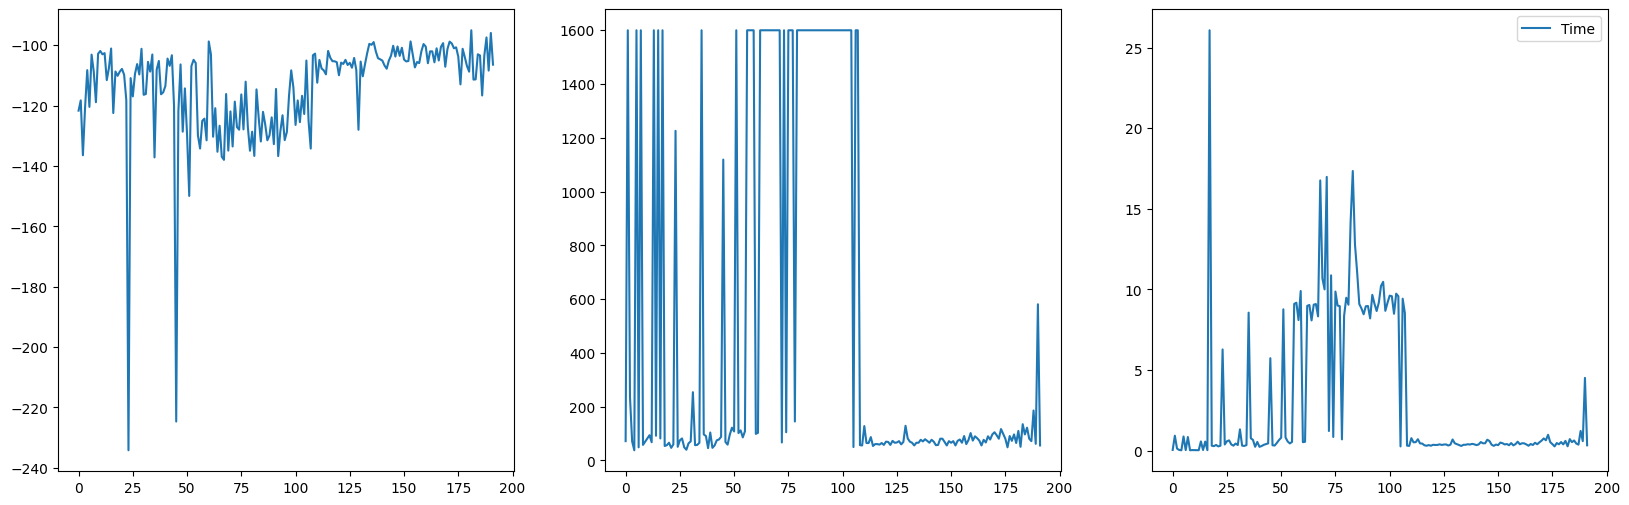

In [35]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

ax1.plot(rs, label='Return')
ax2.plot(ls, label='Length')
ax3.plot(ts, label='Time')
plt.legend()
plt.show()

In [36]:
eval_env = gym.make("BipedalWalker-v3", render_mode="rgb_array") #
eval_env = wrap_gym(eval_env, rescale_actions=True)
eval_env = gym.wrappers.RecordVideo(eval_env, 'cartpole_video')
eval_env = gym.wrappers.RecordEpisodeStatistics(eval_env, buffer_length=1)
evaluate(agent, eval_env, num_episodes=1)
eval_env.close()